Early Spring Data Exploration 
========================

* Frame the problem and look at the big picture
* Get the data



### **Imports**

In [1]:
# All of your imports here 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import os

### **Extra Functions To Use**

In [2]:
# def new_date_features(data):
 ##   data['year'] = data['date'].dt.year
 #   data['month'] = data['date'].dt.month
  #  data['day'] = data['date'].dt.day
 #   return data

def drop_enso_columns(data):

    features_to_drop = [
        # 'global temperature anomalies',
        'Nino 1+2 SST',
        'Nino 1+2 SST Anomalies',
        'Nino 3 SST',
        'Nino 3 SST Anomalies',
        'Nino 3.4 SST',
        'Nino 3.4 SST Anomalies',
        'Nino 4 SST',
        'Nino 4 SST Anomalies',
        'TNI',
        'PNA',
        'OLR',
        'SOI',
        'MEI.v2',
        'Season (2-Month)',
        'Season (3-Month)',
        'Season (12-Month)',
        'ENSO Phase-Intensity'
    ]

    data = data.drop(columns=features_to_drop)

    return data

def read_weather_data(filename):
    """
    Reads weather data from the given file. M values are assumed to be
    missing values (returned as nan). T values are trace values and returned as
    0.0025 inches for precipitation and snowfall and 0.025 inches for snowdepth
    (see https://www.chicagotribune.com/news/weather/ct-wea-asktom-0415-20180413-column.html).
    All temperatures are in Fahrenheit and all precipitation values are in inches.
    """
    def convert_precipitation(raw):
        return 0.0025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    def convert_depth(raw):
        return 0.025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    return pd.read_csv(filename, na_values=['M'], parse_dates=[0],
        converters={
            "precipitation":convert_precipitation,
            "snowfall":convert_precipitation,
            "snowdepth":convert_depth,
        },
        names=["date","max_temp","min_temp","avg_temp","precipitation","snowfall","snowdepth"],
        header=0
    )


### **Pivoting The Data**

In [3]:
# def pivot_enso():
#     data = pd.read_csv('ENSO.csv', parse_dates=['date'])

#     dat = data.copy()
#     dat['year'] = dat.date.dt.year
#     dat['year'] = dat.apply(lambda row: row['year'] + 1 if row['date'].month >= 3 else row['year'], axis=1) # trying to move months after february up one year.
#     dat['month'] = dat.date.dt.month
#     dat = dat.drop(columns=['date'])
#     dat_pivoted = dat.pivot(index='year', columns='month')
#     dat_pivoted.columns = ["_".join(str(x) for x in a) for a in dat_pivoted.columns.to_flat_index()]
#     return dat_pivoted

# def pivot_soil():
#     data = pd.read_csv('soil.csv', parse_dates=['day'])

#     dat = data.copy()
#     dat['year'] = dat.day.dt.year
#     dat['day_of_year'] = dat.day.dt.day_of_year
#     dat = dat.drop(columns=['day']).pivot(index='year', columns='day_of_year')
#     dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]

#     return dat

# def pivot_weather():
#     data = read_weather_data('weather.csv')

#     dat = data.copy()
#     dat['year'] = dat.date.dt.year
#     dat['day_of_year'] = dat.date.dt.day_of_year
#     dat = dat.drop(columns=['date']).pivot(index='year', columns='day_of_year')
#     dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]

#     return dat

#### **Merging The Data**

In [4]:
def pivot(dataset=None, column='date'):
    data = dataset.copy()

    dat = data.copy()
    dat['year'] = dat[column].dt.year
    dat['day_of_year'] = dat[column].dt.day_of_year
    dat = dat.drop(columns=[column]).pivot(index='year', columns='day_of_year')
    dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]

    return dat

def pivot_enso(dataset=None, column='date'):

    dat = dataset.copy()
    dat['year'] = dat.date.dt.year
    dat['year'] = dat.apply(lambda row: row['year'] + 1 if row['date'].month >= 3 else row['year'], axis=1) # moving months after february up one year.
    dat = dat[dat['year'] >= 1950]
    dat['month'] = dat.date.dt.month
    dat = dat.drop(columns=column)
    dat_pivoted = dat.pivot(index='year', columns='month')
    dat_pivoted.columns = ["_".join(str(x) for x in a) for a in dat_pivoted.columns.to_flat_index()]
    return dat_pivoted

def load_data(weather_filename="weather.csv", soil_filename="soil.csv", phil_pred_filename="phil_pred.csv", early_spring_filename="early_spring.csv"):
    weather = read_weather_data(weather_filename)
    soil = pd.read_csv(soil_filename, parse_dates=[0])
    phil_pred = pd.read_csv(phil_pred_filename)
    early_spring = pd.read_csv(early_spring_filename)
    enso = pd.read_csv('ENSO.csv', parse_dates=['date'])
    enso = drop_enso_columns(enso)
    
    basic_data = (
        pivot(weather, 'date').
        join(pivot(soil, 'day')).
        join(phil_pred.set_index('year')).
        join(early_spring.set_index('year'))
    )
    
    enso_data = pivot_enso(enso, 'date')
    data = enso_data.join(basic_data)
    return data

data = load_data()
data

,global temperature anomalies_1,global temperature anomalies_2,global temperature anomalies_3,global temperature anomalies_4,global temperature anomalies_5,global temperature anomalies_6,global temperature anomalies_7,global temperature anomalies_8,global temperature anomalies_9,global temperature anomalies_10,...,max_soil_moisture_49,max_soil_moisture_50,max_soil_moisture_51,max_soil_moisture_52,max_soil_moisture_53,max_soil_moisture_54,max_soil_moisture_55,max_soil_moisture_56,prediction,early_spring
year,,,,,,,,,,,,,,,,,,,,,
1950,-0.20,-0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.476,0.474,0.469,0.466,0.518,0.495,0.480,0.478,True,False
1951,-0.31,-0.37,-0.08,-0.16,-0.02,-0.02,-0.09,-0.09,-0.06,-0.14,...,0.505,0.519,0.506,0.519,0.493,0.477,0.469,0.463,False,False
1952,0.14,0.11,-0.16,-0.09,0.04,0.03,0.10,0.11,0.17,0.13,...,0.487,0.477,0.512,0.511,0.486,0.483,0.479,0.478,False,True
1953,0.07,0.15,-0.03,0.07,0.08,0.05,0.07,0.06,0.09,0.01,...,0.473,0.494,0.520,0.519,0.480,0.474,0.471,0.465,False,True
1954,-0.20,-0.06,0.14,0.26,0.20,0.21,0.08,0.10,0.07,0.13,...,0.462,0.464,0.467,0.517,0.485,0.474,0.515,0.495,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,1.13,1.19,1.16,1.02,0.90,0.90,0.91,0.91,0.96,1.00,...,0.513,0.506,0.479,0.473,0.470,0.463,0.463,0.472,True,True
2021,0.83,0.66,1.16,1.13,0.99,0.92,0.90,0.89,0.97,0.90,...,0.477,0.471,0.467,0.464,0.486,0.512,0.520,0.518,False,True
2022,0.92,0.91,0.88,0.79,0.81,0.85,0.91,0.83,0.91,0.99,...,0.519,0.490,0.482,0.476,0.520,0.509,0.493,0.514,False,True


# **Predicting Early Spring**

## Business Context
1. **Primary Objective**
   - Predict early spring occurrence before April 1st using weather and soil data
   - Goal: Enable data-driven business decisions for increased profits

2. **Current Solution & Usage**
   - Existing methods rely on traditional, less data-driven approaches
   - New solution will use daily local weather and soil data
   - Predictions must be made before April 1st annually

## Technical Framework
1. **Problem Classification**
   - Type: Supervised binary classification
   - Features: Weather and soil data
   - Requirements: System must adapt to climate changes over time
   - Advantage: Low risk of data manipulation due to weather-based inputs

2. **Performance Metrics**
   - Primary metric: Mean Absolute Error (MAE)
   - Minimum required accuracy: >65% for profitability
   - Benchmark: Must significantly outperform random guessing (50%)

3. **Methodology**
   - Leverage existing tools from:
     - Weather prediction models
     - Agricultural forecasting
     - Time series analysis
   - Manual approach: Compare historical patterns in temperature and related data to identify early spring indicators

## Assumptions & Considerations
1. **Key Assumptions**
   - Data collection is reliable and consistent across years
   - Climate change impact is gradual
   - 5-day period before April 1st is crucial for prediction

2. **Open Questions**
   - Availability of human expertise needs to be determined
   - Validation methods for assumptions
   - Integration with existing business processes

## Areas for Further Investigation
1. **Data Requirements**
   - Historical data availability and quality
   - Additional relevant data sources
   - Data collection and storage methods

2. **Implementation Strategy**
   - System deployment plan
   - Monitoring and maintenance requirements
   - Update/retraining schedule



---

# **Get the Data**

1. **List the data you need and how much you need:**
    - Historical weather data (temperature, precipitation, snowfall)
    - Soil temperature and moisture data
    - Early spring occurrence data
    - Groundhog Day predictions (if available)

2. **Find and document where you can get that data:**
    
    - N/A right now

3. **Get access authorizations**: Most of this data should be publicly available, but some soil data might require permission from agricultural departments.

4. **Create a workspace**: This notebook.

5. **Get the data**: 
    - Downloaded early_spring.csv, phil_pred.csv, soil.csv, and weather.csv files
    - These files contain the necessary historical data for our analysis

6. **Convert the data to a format you can easily manipulate**:
   - Data is provided in CSV files, which are easy to use with pandas
   - We've already merged the data into a single combined_data.csv file for easier manipulation

7. **Ensure sensitive information is deleted or protected**: The data appears to be anonymized and doesn't contain sensitive information.

8. **Check the size and type of data (time series, geographical, …)**: <mark>TODO</mark>: Report your information below. At this point, since you don't want to look at the data too closely, this is a quick evaluation about the number of features, the number of samples, and any special considerations about the features such as:
   1. Is it a time series? (Yes, the data is time-based with daily measurements)
   2. Are any of the features not available for the business problem? (We need to ensure we're only using data available before April 1st for predictions)
   3. Which feature(s) will be used as the target/label for the business problem? (The 'early_spring' column from early_spring.csv is likely our target variable)
   4. Should any of the features be stratified during the train/test split to avoid sampling biases? (We might want to stratify by year to ensure we have a good distribution of early spring and non-early spring years in both train and test sets)


#### **Load The Data**

In [5]:
data = load_data()
data
data.to_csv('combined_data.csv')

#### **Looking At The Features**

In [6]:
data.shape

(75, 698)

#### **Dropping Features With Only Missing Values**

In [7]:
empty_columns = data.columns[data.isna().all()].tolist()
for column in empty_columns:
    print(f"Column {column} is empty. Dropping it.")
    data.drop(column, axis=1, inplace=True)

#### **Missing Percentages**

In [8]:
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

global temperature anomalies_1     1.333333
global temperature anomalies_2     1.333333
global temperature anomalies_3     1.333333
global temperature anomalies_4     1.333333
global temperature anomalies_5     1.333333
                                    ...    
max_soil_moisture_54              10.666667
max_soil_moisture_55              10.666667
max_soil_moisture_56              10.666667
prediction                        10.666667
early_spring                      10.666667
Length: 698, dtype: float64


 ### **Displaying The First 5 Rows Of The Data**

In [9]:
pd.set_option('display.max_columns', None)

data.head() 


,global temperature anomalies_1,global temperature anomalies_2,global temperature anomalies_3,global temperature anomalies_4,global temperature anomalies_5,global temperature anomalies_6,global temperature anomalies_7,global temperature anomalies_8,global temperature anomalies_9,global temperature anomalies_10,global temperature anomalies_11,global temperature anomalies_12,ONI_1,ONI_2,ONI_3,ONI_4,ONI_5,ONI_6,ONI_7,ONI_8,ONI_9,ONI_10,ONI_11,ONI_12,max_temp_1,max_temp_2,max_temp_3,max_temp_4,max_temp_5,max_temp_6,max_temp_7,max_temp_8,max_temp_9,max_temp_10,max_temp_11,max_temp_12,max_temp_13,max_temp_14,max_temp_15,max_temp_16,max_temp_17,max_temp_18,max_temp_19,max_temp_20,max_temp_21,max_temp_22,max_temp_23,max_temp_24,max_temp_25,max_temp_26,max_temp_27,max_temp_28,max_temp_29,max_temp_30,max_temp_31,max_temp_32,max_temp_33,max_temp_34,max_temp_35,max_temp_36,max_temp_37,max_temp_38,max_temp_39,max_temp_40,max_temp_41,max_temp_42,max_temp_43,max_temp_44,max_temp_45,max_temp_46,max_temp_47,max_temp_48,max_temp_49,max_temp_50,max_temp_51,max_temp_52,max_temp_53,max_temp_54,max_temp_55,max_temp_56,min_temp_1,min_temp_2,min_temp_3,min_temp_4,min_temp_5,min_temp_6,min_temp_7,min_temp_8,min_temp_9,min_temp_10,min_temp_11,min_temp_12,min_temp_13,min_temp_14,min_temp_15,min_temp_16,min_temp_17,min_temp_18,min_temp_19,min_temp_20,min_temp_21,min_temp_22,min_temp_23,min_temp_24,min_temp_25,min_temp_26,min_temp_27,min_temp_28,min_temp_29,min_temp_30,min_temp_31,min_temp_32,min_temp_33,min_temp_34,min_temp_35,min_temp_36,min_temp_37,min_temp_38,min_temp_39,min_temp_40,min_temp_41,min_temp_42,min_temp_43,min_temp_44,min_temp_45,min_temp_46,min_temp_47,min_temp_48,min_temp_49,min_temp_50,min_temp_51,min_temp_52,min_temp_53,min_temp_54,min_temp_55,min_temp_56,avg_temp_1,avg_temp_2,avg_temp_3,avg_temp_4,avg_temp_5,avg_temp_6,avg_temp_7,avg_temp_8,avg_temp_9,avg_temp_10,avg_temp_11,avg_temp_12,avg_temp_13,avg_temp_14,avg_temp_15,avg_temp_16,avg_temp_17,avg_temp_18,avg_temp_19,avg_temp_20,avg_temp_21,avg_temp_22,avg_temp_23,avg_temp_24,avg_temp_25,avg_temp_26,avg_temp_27,avg_temp_28,avg_temp_29,avg_temp_30,avg_temp_31,avg_temp_32,avg_temp_33,avg_temp_34,avg_temp_35,avg_temp_36,avg_temp_37,avg_temp_38,avg_temp_39,avg_temp_40,avg_temp_41,avg_temp_42,avg_temp_43,avg_temp_44,avg_temp_45,avg_temp_46,avg_temp_47,avg_temp_48,avg_temp_49,avg_temp_50,avg_temp_51,avg_temp_52,avg_temp_53,avg_temp_54,avg_temp_55,avg_temp_56,precipitation_1,precipitation_2,precipitation_3,precipitation_4,precipitation_5,precipitation_6,precipitation_7,precipitation_8,precipitation_9,precipitation_10,precipitation_11,precipitation_12,precipitation_13,precipitation_14,precipitation_15,precipitation_16,precipitation_17,precipitation_18,precipitation_19,precipitation_20,precipitation_21,precipitation_22,precipitation_23,precipitation_24,precipitation_25,precipitation_26,precipitation_27,precipitation_28,precipitation_29,precipitation_30,precipitation_31,precipitation_32,precipitation_33,precipitation_34,precipitation_35,precipitation_36,precipitation_37,precipitation_38,precipitation_39,precipitation_40,precipitation_41,precipitation_42,precipitation_43,precipitation_44,precipitation_45,precipitation_46,precipitation_47,precipitation_48,precipitation_49,precipitation_50,precipitation_51,precipitation_52,precipitation_53,precipitation_54,precipitation_55,precipitation_56,snowfall_1,snowfall_2,snowfall_3,snowfall_4,snowfall_5,snowfall_6,snowfall_7,snowfall_8,snowfall_9,snowfall_10,snowfall_11,snowfall_12,snowfall_13,snowfall_14,snowfall_15,snowfall_16,snowfall_17,snowfall_18,snowfall_19,snowfall_20,snowfall_21,snowfall_22,snowfall_23,snowfall_24,snowfall_25,snowfall_26,snowfall_27,snowfall_28,snowfall_29,snowfall_30,snowfall_31,snowfall_32,snowfall_33,snowfall_34,snowfall_35,snowfall_36,snowfall_37,snowfall_38,snowfall_39,snowfall_40,snowfall_41,snowfall_42,snowfall_43,snowfall_44,snowfall_45,snowfall_46,snowfall_47,snowfall_48,snowfall_49,snowfall_50,snowfall_51,snowfall_52,sn

#### **Correlation Heatmap Of Numeric Features**

- From what we can see the correlation matrix reveals strong relationships within soil temperature measures and within soil moisture measures, but weaker connections between temperature and moisture. For example, there's little correlation between soil conditions and time features like year, month, or day.
- This basically means that soil temperature and moisture levels are generally consistent on their own, but they don't always change in sync with each other and don't follow clear seasonal or time-based patterns

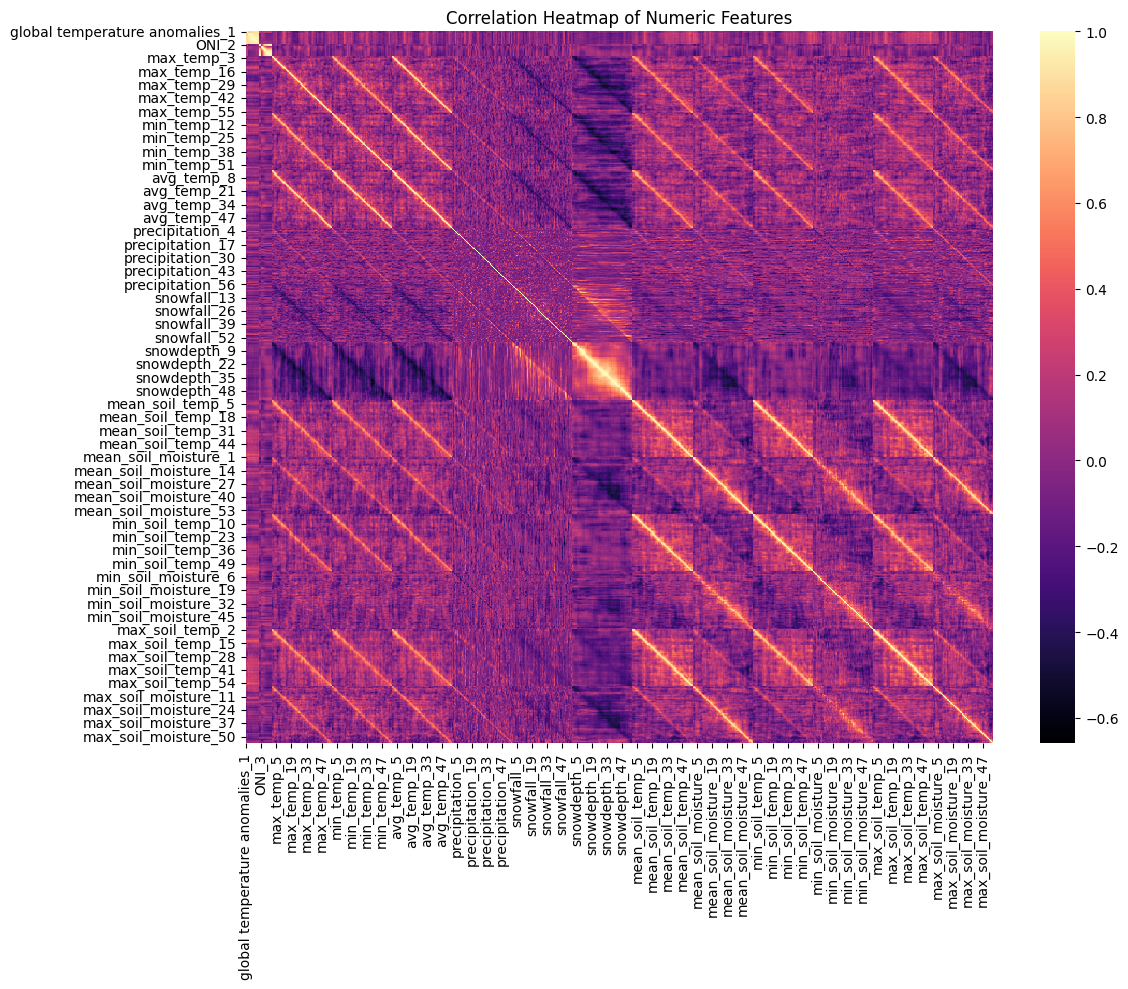

In [10]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()

#### **Correlation Heatmap Of Mean And Average Features**


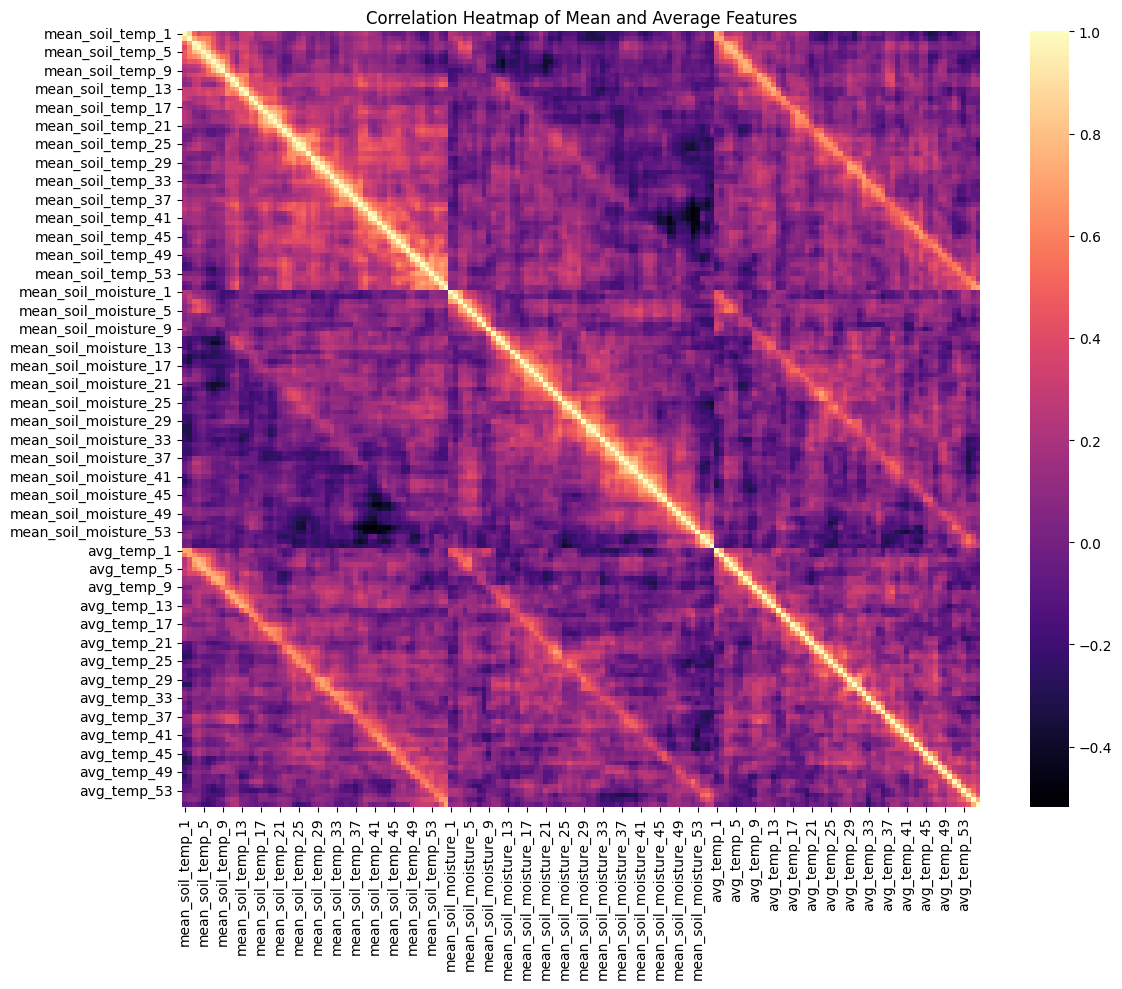

In [11]:
mean_columns = [mean for mean in data.columns if 'mean' in mean]
avg_columns = [avg for avg in data.columns if 'avg' in avg]
numeric_columns = data[mean_columns + avg_columns].select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Mean and Average Features')
plt.tight_layout()

### **Mean Soil Temperature Across Time Points**

- The graph shows soil temperatures from five locations, ranging from -10°C to +12°C over about 80 samples. The lines track closely together, indicating similar temperature changes. Notable spikes occur around samples 5, 50, and 75, with a drop between samples 65 and 70. Overall, soil temperatures are mostly consistent across the area, with minor differences between locations.


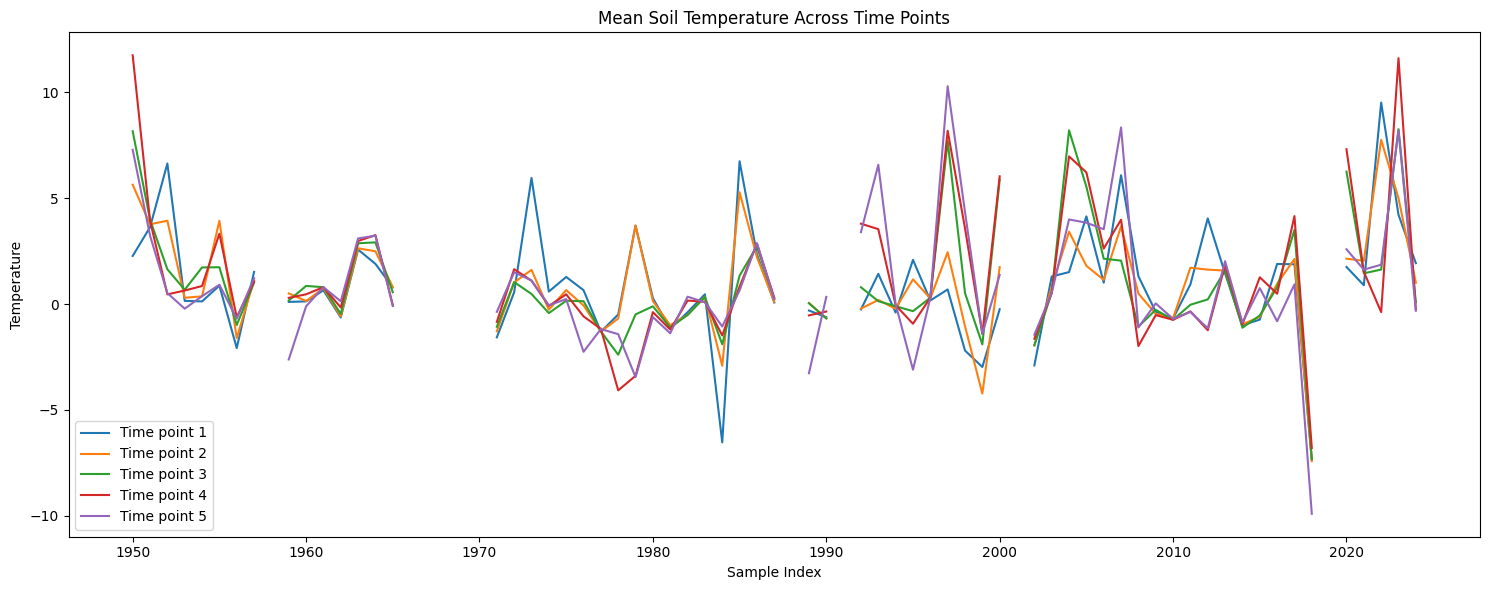

In [12]:
plt.figure(figsize=(15, 6))
soil_temp_cols = [col for col in data.columns if 'soil_temp' in col and 'mean' in col][:5]  # First 5 time points
for col in soil_temp_cols:
    plt.plot(data.index, data[col], label=f'Time point {col.split("_")[-1]}')
plt.title('Mean Soil Temperature Across Time Points')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()


### **Soil Moisture Distribution**

This boxplot displays soil moisture levels measured at five different times, ranging from about 0.44 to 0.51. The median moisture level (indicated by the red lines) is stable at around 0.47 across all time points. The similar sizes of the boxes and whiskers suggest that soil moisture is fairly consistent with little variation between measurements.


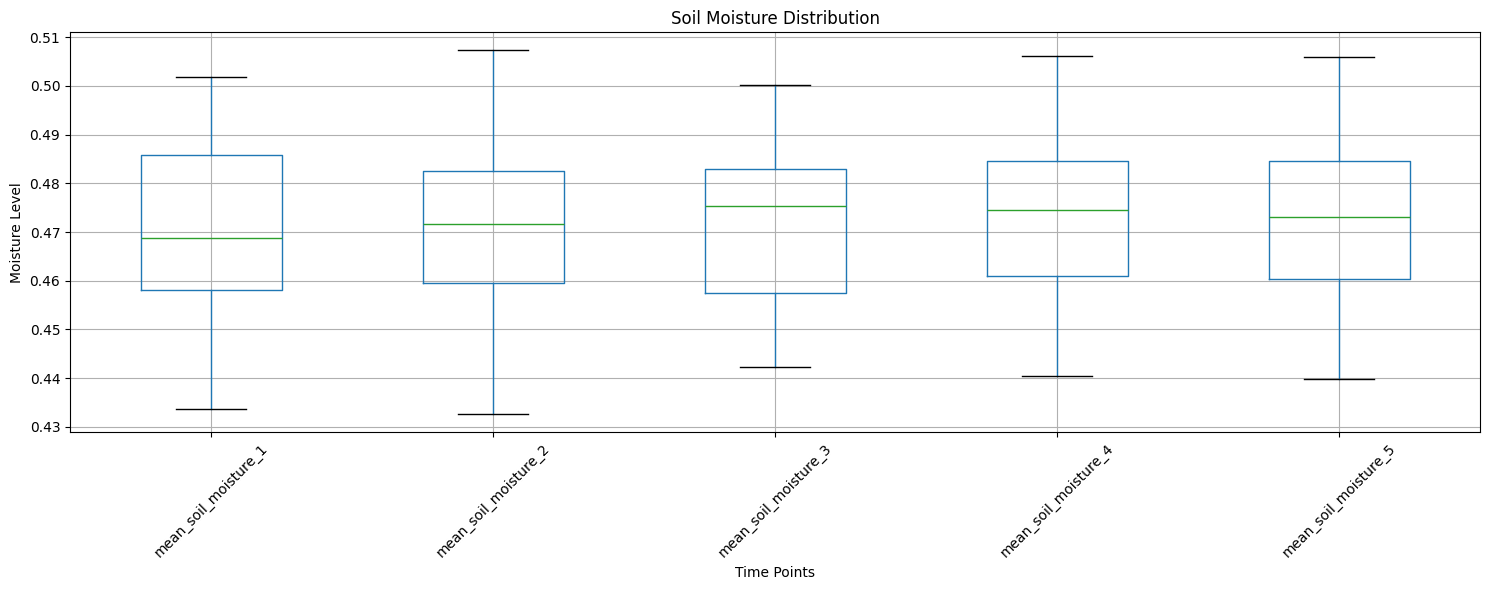

In [13]:
plt.figure(figsize=(15, 6))
moisture_cols = [col for col in data.columns if 'soil_moisture' in col and 'mean' in col][:5]
data[moisture_cols].boxplot()
plt.title('Soil Moisture Distribution')
plt.xlabel('Time Points')
plt.ylabel('Moisture Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Temperature Vs Moisture Relationship**


- This scatter plot shows the relationship between soil temperature (x-axis: -7.5°C to 10°C) and soil moisture (y-axis: 0.44 to 0.51), with color intensity indicating data density. Most points cluster around 0°C and 0.47-0.49 moisture levels, but there’s no strong linear relationship, suggesting the two variables are mostly independent.

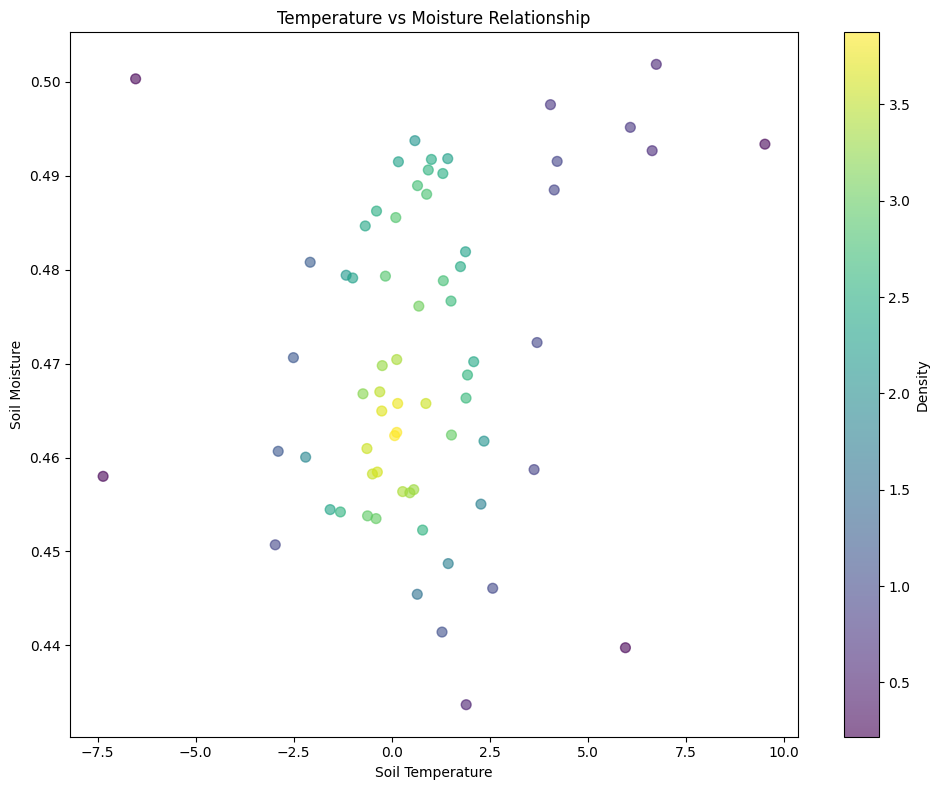

In [14]:
plt.figure(figsize=(10, 8))
if soil_temp_cols and moisture_cols:
    x = data[soil_temp_cols[0]]  # First time point
    y = data[moisture_cols[0]]
    
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # Create density scatter plot
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    scatter = plt.scatter(x, y, c=z, s=50, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Density')
    
plt.title('Temperature vs Moisture Relationship')
plt.xlabel('Soil Temperature')
plt.ylabel('Soil Moisture')
plt.tight_layout()
plt.show()


### **Soil Temperature Trend With Uncertainty**

The graph displays soil temperature changes from 1950 to 2020. The red line shows the average temperature, while the pink area shows how much the temperature can vary. You can see spikes in temperature around 1950, 1990, and 2015. Most of the time, the temperature stayed between -2.5°C and 5°C, but it dropped sharply to -7.5°C close to 2020.


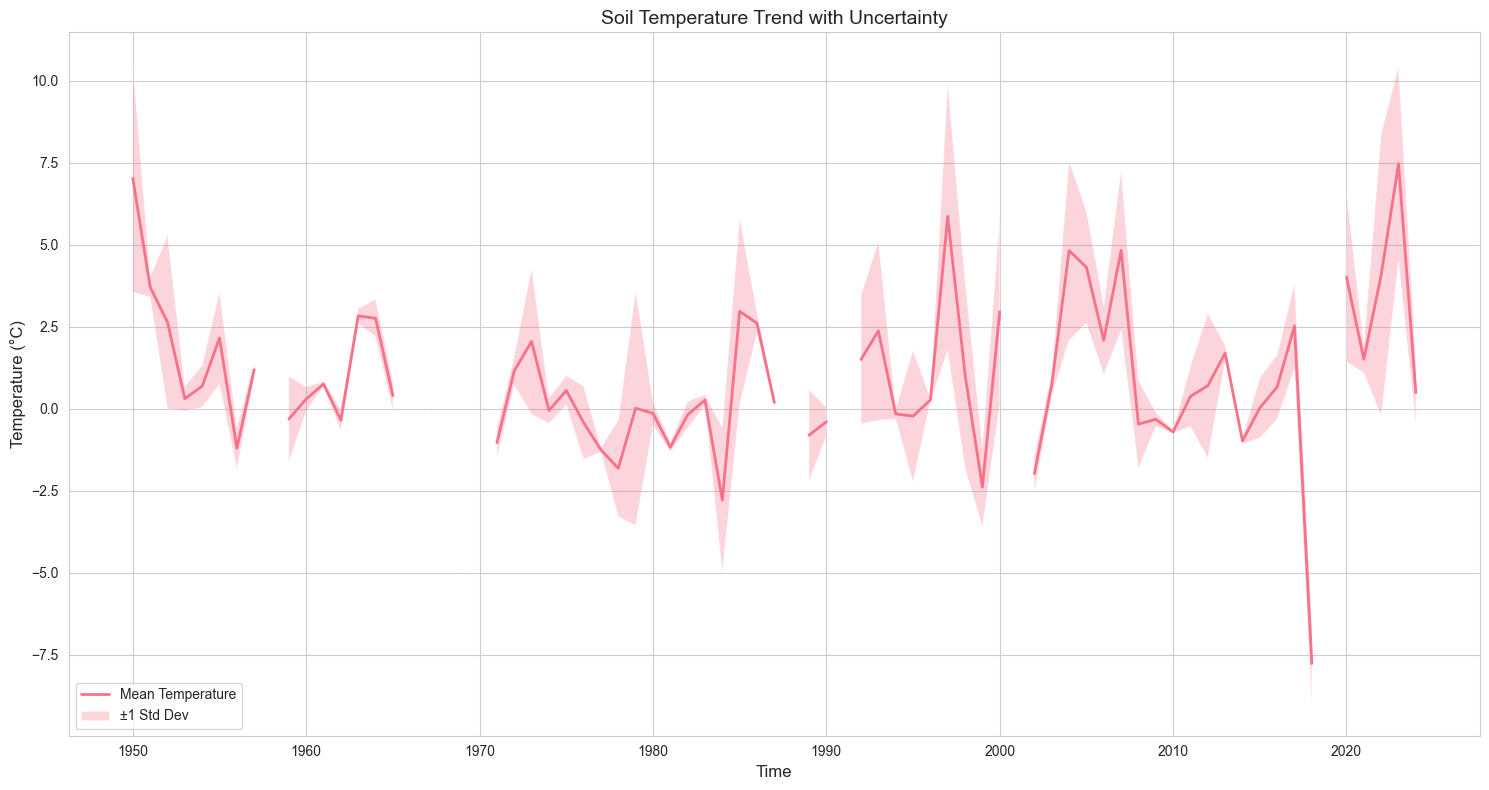

In [15]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_palette("husl")

temp_mean = data[soil_temp_cols].mean(axis=1)
temp_std = data[soil_temp_cols].std(axis=1)

plt.plot(data.index, temp_mean, label='Mean Temperature', linewidth=2)
plt.fill_between(data.index, 
                 temp_mean - temp_std, 
                 temp_mean + temp_std, 
                 alpha=0.3,
                 label='±1 Std Dev')
plt.title('Soil Temperature Trend with Uncertainty', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### **Temperature Vs Moisture With Distributions**


This graph shows the relationship between soil temperature (x-axis) and soil moisture (y-axis), with histograms on the sides showing how often each value appears. The red line shows a slight positive trend, meaning that as temperature increases, moisture tends to increase a little too. However, the points are scattered, so the relationship isn't strong. The histograms indicate that most temperatures are around 0°C, while moisture levels are mostly between 0.46 and 0.49.

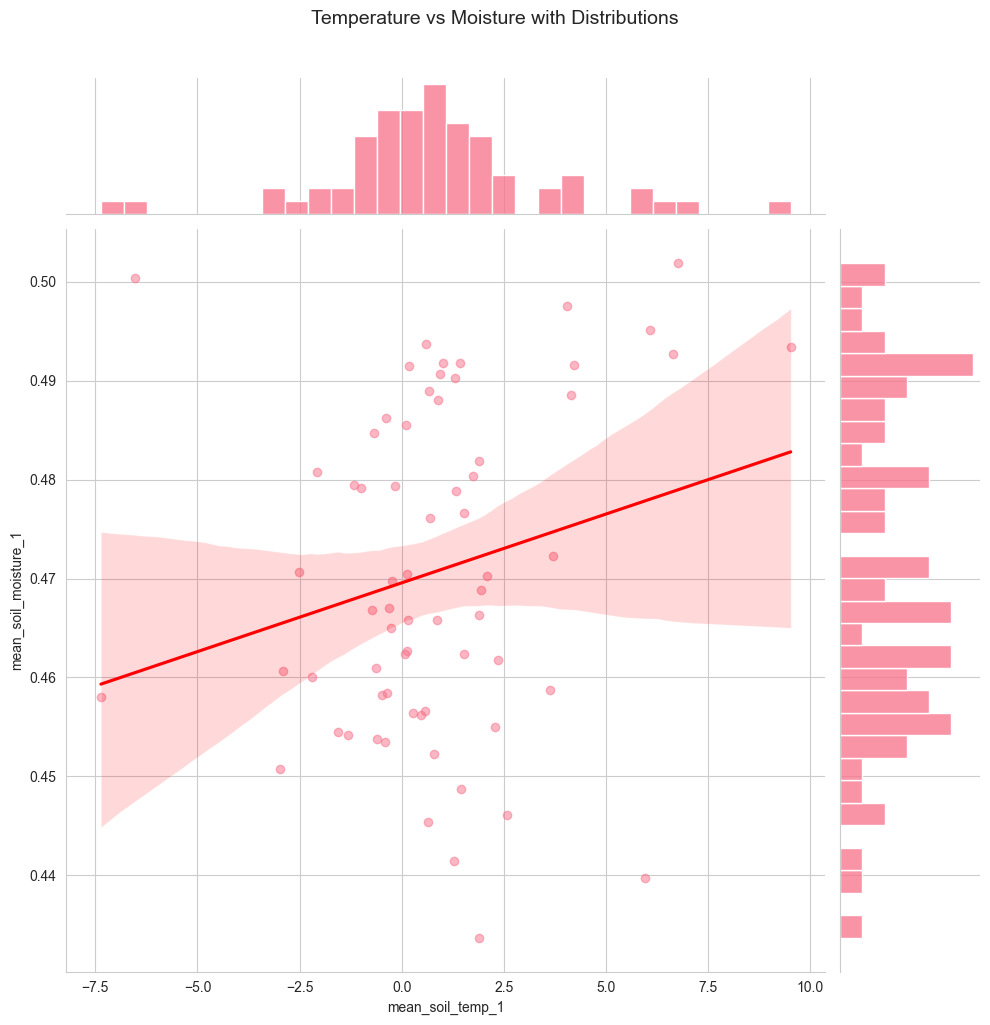

In [16]:
g = sns.JointGrid(data=data, 
                  x=soil_temp_cols[0],
                  y=moisture_cols[0],
                  height=10)
g = g.plot_joint(sns.regplot, 
                 scatter_kws={'alpha':0.5},
                 line_kws={'color': 'red'})
g = g.plot_marginals(sns.histplot, bins=30)
g.fig.suptitle('Temperature vs Moisture with Distributions', y=1.02, fontsize=14)
plt.tight_layout()


### **Temperature vs Moisture Density Distribution**


This density plot shows how soil temperature and moisture levels are distributed together. The bright yellow area around 0°C and 0.46 moisture indicates where most measurements are found. The colors range from purple (less common) to yellow (most common). There's also a purple spot at -5°C, showing a different group with higher moisture levels.

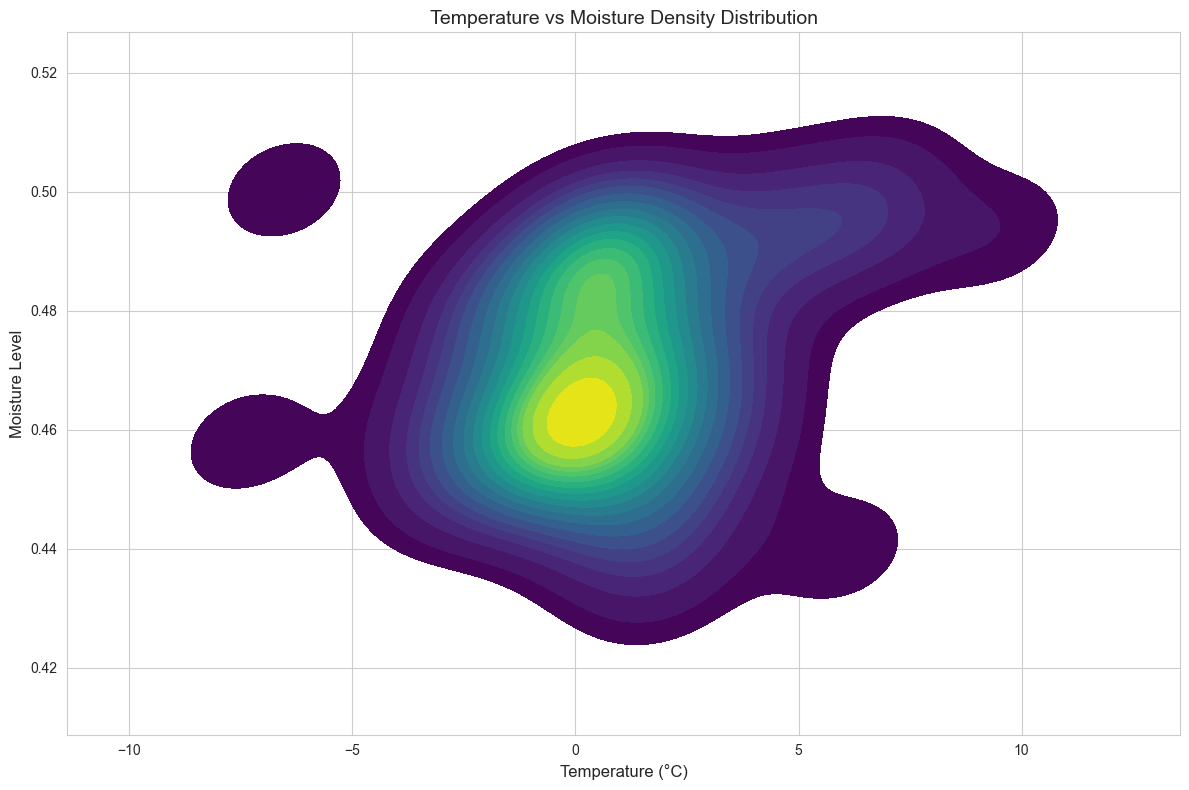

In [17]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data,
            x=soil_temp_cols[0],
            y=moisture_cols[0],
            cmap='viridis',
            fill=True,
            levels=20)
plt.title('Temperature vs Moisture Density Distribution', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Moisture Level', fontsize=12)
plt.tight_layout()
plt.show()

#### **Splitting The Data**

In [18]:
def split_data():
    train_set, test_set = train_test_split(data, test_size=0.2, random_state=7)
    return train_set, test_set

In [19]:
train_set, test_set = split_data()
data = train_set.copy()

#### **Missing Percentages**

In [20]:
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

global temperature anomalies_1    1.666667
global temperature anomalies_2    1.666667
global temperature anomalies_3    1.666667
global temperature anomalies_4    1.666667
global temperature anomalies_5    1.666667
                                    ...   
max_soil_moisture_54              6.666667
max_soil_moisture_55              6.666667
max_soil_moisture_56              6.666667
prediction                        6.666667
early_spring                      6.666667
Length: 698, dtype: float64


#### **Removing The Empty Data From Early Spring For Later Use When Training The Model**

In [21]:
print(train_set['early_spring'].isnull().sum())
train_set = train_set.dropna(subset=['early_spring'])
print(train_set['early_spring'].isnull().sum())

4
0


# Prepare the Data

Note: the word *optional* simply means not all datasets will require it, it does not mean you can just choose not to do it if it is needed for a particular dataset.

- **A.** Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median…) or drop rows/columns 
- **B.** Feature selection (optional): Drop attributes that provide no useful information for the task 
- **C.** Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, …), Add promising transformations of features ($\log(x)$, $\sqrt{x}$, $x^2$, …); Aggregate features into promising new features 
- **D.** Feature scaling: standardize or normalize features 



### **Transformers**

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd


def get_columns_by_type(X):
    numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
    return numerical_columns, categorical_columns

# Define pipeline
def create_preprocessing_pipeline(data):
    numerical_columns, categorical_columns = get_columns_by_type(data)

    # Impute missing values and scale numerical features
    numerical_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])

    # One-hot encode categorical features
    categorical_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    # ColumnTransformer to handle both numerical and categorical columns
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor)
    ])

    return pipeline

# Usage example
pipeline = create_preprocessing_pipeline(data)
data_transformed = pipeline.fit_transform(data)

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['global temperature '
                                                   'anomalies_1',
                                                   'global temperature '
                                                   'anomalies_2',
                                                   'global temperature '
                                                   'anomalies_3',
                                                   'global temperature '
                                                   'anomalies_4',
                                                   'global temperature '
                                                   'anomalies_5',
                                                   'global temperature '
                                                   'anomalies_6',
                                                   'global...
                                                   'ONI_1', 'ONI_2', 'ONI_3',
                                                   'ONI_4', 'ONI_5', 'ONI_6',
                                                   'ONI_7', 'ONI_8', 'ONI_9',
                                                   'ONI_10', 'ONI_11', 'ONI_12',
                                                   'max_temp_1', 'max_temp_2',
                                                   'max_temp_3', 'max_temp_4',
                                                   'max_temp_5', 'max_temp_6', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['prediction',
                                                   'early_spring'])]))])

### **Splitting The Data Into Features And Target**

In [33]:
X = train_set.drop(columns=['early_spring'])
y = train_set['early_spring'].copy()

### **Creating The Pipeline To Do A Fit And Transform**

In [34]:
pipeline = create_preprocessing_pipeline(X)
X_transformed = pipeline.fit_transform(X)

- *Had to make sure that the X and y had the same amount of samples since that changed as X was being transformed*

In [35]:
# Ensure X_transformed and y have the same number of samples
if X_transformed.shape[0] != y.shape[0]:
    # Align X and y by filtering y to match X_transformed's length
    y = y.iloc[:X_transformed.shape[0]].reset_index(drop=True)

### **Testing different classification models**

- This code defines a list of different classification models than fits them with the transformed data and measures the accuracy, recall and f1.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Sgd Classifier': SGDClassifier()
}

X_transformed = pipeline.fit_transform(X)
y = y.reset_index(drop=True).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

for name, model in models.items():
    mod = model
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"{name}:\n {report}")
    print("Confusion Matrix:")
    print(conf_matrix)

    cross_val_scores = cross_val_score(mod, X_train, y_train, cv=5)
    print(f"Cross Validation Scores: {cross_val_scores}")

Decision Tree:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.75      0.43      0.55         7

    accuracy                           0.58        12
   macro avg       0.62      0.61      0.58        12
weighted avg       0.65      0.58      0.57        12

Confusion Matrix:
[[4 1]
 [4 3]]
Cross Validation Scores: [0.55555556 0.66666667 0.77777778 0.55555556 0.5       ]
Logistic Regression:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.71      0.83         7

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12

Confusion Matrix:
[[5 0]
 [2 5]]
Cross Validation Scores: [0.55555556 1.         0.88888889 0.55555556 0.5       ]
K-Nearest Neighbors:
               precision    recall  f1-score   support

 

c:\Users\Colea\Desktop\CodingProjects\MachineLearning\SpringPredictor-ML\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Colea\Desktop\CodingProjects\MachineLearning\SpringPredictor-ML\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Colea\Desktop\CodingProjects\MachineLearning\SpringPredictor-ML\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Colea\Desktop\CodingProjects\MachineLearning\SpringPredictor-ML\.venv\Lib\site-packages\

Cross Validation Scores: [0.22222222 0.55555556 0.44444444 0.33333333 0.5       ]
Support Vector Machine:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.71      0.83         7

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12

Confusion Matrix:
[[5 0]
 [2 5]]
Cross Validation Scores: [0.55555556 0.88888889 0.66666667 0.66666667 0.375     ]
Naive Bayes:
               precision    recall  f1-score   support

           0       0.44      0.80      0.57         5
           1       0.67      0.29      0.40         7

    accuracy                           0.50        12
   macro avg       0.56      0.54      0.49        12
weighted avg       0.57      0.50      0.47        12

Confusion Matrix:
[[4 1]
 [5 2]]
Cross Validation Scores: [0.33333333 0.66666667 0.66666667 0.55555556 0.75   

### **Using Logistic Regression Model**

- Using the logistic regression model, we achieved an accuracy of approximately 63.64%. This means that about two-thirds of the predictions of model were correct. 

- True Negatives (TN): 4 (correctly predicted as False)
- False Positives (FP): 2 (incorrectly predicted as True)
- False Negatives (FN): 2 (incorrectly predicted as False)
- True Positives (TP): 3 (correctly predicted as Te)

In [30]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Fit and transform X, and reset index to align with the new X_transformed
X_transformed = pipeline.fit_transform(X)
y = y.reset_index(drop=True)
y = y.astype(int)

# Now split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Create the Logistic Regression model
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8333333333333334
Confusion Matrix:
[[5 0]
 [2 5]]


In [31]:

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

results['Correct'] = results['Actual'] == results['Predicted']

print(results)


    Actual  Predicted  Correct
0        1          1     True
5        0          0     True
33       0          0     True
13       1          1     True
19       0          0     True
50       1          1     True
36       1          0    False
26       1          1     True
44       1          1     True
12       0          0     True
54       0          0     True
3        1          0    False
